<a href="https://colab.research.google.com/github/devshah21/nuclei_segmentation/blob/main/nuclei_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile

In [134]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [137]:
with ZipFile('gdrive/MyDrive/google_colab_files/stage1_train.zip', 'r') as zipObj:
  zipObj.extractall('gdrive/MyDrive/google_colab_files/traindata1')

In [139]:
with ZipFile('gdrive/MyDrive/google_colab_files/stage1_test.zip', 'r') as zipObj:
  zipObj.extractall('gdrive/MyDrive/google_colab_files/testdata1')

In [172]:
traindatapath = '/content/gdrive/MyDrive/google_colab_files/traindata1/'
testdatapath = '/content/gdrive/MyDrive/google_colab_files/testdata1/'

In [254]:
import os

In [255]:
testids = next(os.walk(testdatapath))[1]

In [285]:
trainids = next(os.walk(traindatapath))[1]

In [286]:
seed = 37
np.random.seed = seed

imgwidth = 128
imgheight = 128
channels = 3

In [258]:
inputs = tf.keras.layers.Input((imgwidth, imgheight, channels))

In [259]:
import numpy as np

xtrain = np.zeros((len(trainids), imgheight, imgwidth, channels), dtype=np.uint8)
ytrain = np.zeros((len(trainids), imgheight, imgwidth, 1), dtype=np.bool_)

In [260]:
import random
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf

In [261]:
from tqdm import tqdm
for i, id in tqdm(enumerate(trainids), total=len(trainids)):
  paths = traindatapath + id #path to image
  image = imread(paths + '/images/' + id + '.png')[:,:,:channels]
  image = resize(image, (imgheight, imgwidth), mode = 'constant', preserve_range=True)
  xtrain[i] = image #add values to empty array 
  mask = np.zeros((imgheight, imgwidth, 1), dtype=np.bool_)
  for maskpath in next(os.walk(paths + '/masks/'))[2]: #loop through each mask
    masks1 = imread(paths + '/masks/' + maskpath)
    masks1 =  np.expand_dims(resize(masks1, (imgheight, imgwidth), mode='constant', preserve_range=True), axis = -1)
    mask = np.maximum(mask, masks1)
  ytrain[i] = mask

100%|██████████| 670/670 [09:06<00:00,  1.23it/s]


In [262]:
print(image)

[[[ 3.72753906  3.72753906  3.72753906]
  [ 3.8125      3.8125      3.8125    ]
  [ 2.90625     2.90625     2.90625   ]
  ...
  [ 3.90625     3.90625     3.90625   ]
  [ 3.87988281  3.87988281  3.87988281]
  [ 3.64257812  3.64257812  3.64257812]]

 [[ 4.65136719  4.65136719  4.65136719]
  [ 4.20214844  4.20214844  4.20214844]
  [ 4.          4.          4.        ]
  ...
  [ 4.          4.          4.        ]
  [ 4.          4.          4.        ]
  [ 3.87988281  3.87988281  3.87988281]]

 [[ 7.96875     7.96875     7.96875   ]
  [ 5.8125      5.8125      5.8125    ]
  [ 4.          4.          4.        ]
  ...
  [ 4.          4.          4.        ]
  [ 3.71875     3.71875     3.71875   ]
  [ 2.90625     2.90625     2.90625   ]]

 ...

 [[ 2.90625     2.90625     2.90625   ]
  [ 4.          4.          4.        ]
  [ 4.          4.          4.        ]
  ...
  [26.         26.         26.        ]
  [26.75       26.75       26.75      ]
  [26.8125     26.8125     26.8125    ]]

 [

In [263]:
xtest = np.zeros((len(testids), imgheight, imgwidth, channels), dtype = np.uint8)
testsizes = []
#resize test images now
for i, id1 in enumerate(testids):
  paths = testdatapath + id1
  image = imread(paths + '/images/' + id1 + '.png')[:,:,:channels]
  testsizes.append([image.shape[0], image.shape[1]])
  image = resize(image, (imgheight, imgwidth), mode = 'constant', preserve_range=True)
  xtest[i] = image

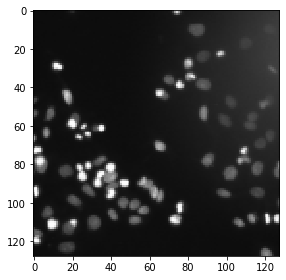

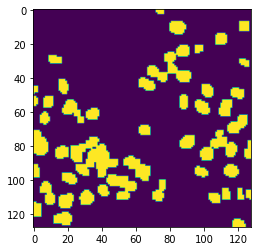

In [264]:
xvalue = random.randint(0, len(trainids))
imshow(xtrain[xvalue])
plt.show()
image = ytrain[xvalue]
image = image.astype(np.uint8)
image = np.squeeze(image)
plt.imshow(image)
plt.show()

Define the UNET Architecture now








In [265]:
# Convert the integer values for the model into float values by dividing by 255. 
values = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Define the first conv layer, input the parameters from the U-Net diagram
conv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(values)
# Prevent overfitting by using dropout function
conv1 = tf.keras.layers.Dropout(0.1)(conv1)
conv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
down1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)

Repeat the following paramaters for the rest of the UNET model. The main focus here is to just define the structure/architecture for UNET.

In [266]:
conv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(down1)
conv2 = tf.keras.layers.Dropout(0.1)(conv2)
conv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
down2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)

In [267]:
conv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(down2)
conv3 = tf.keras.layers.Dropout(0.2)(conv3)
conv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
down3 = tf.keras.layers.MaxPooling2D((2,2))(conv3)

In [268]:
conv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(down3)
conv4 = tf.keras.layers.Dropout(0.2)(conv4)
conv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
down4 = tf.keras.layers.MaxPooling2D(pool_size =(2,2))(conv4)

In [269]:
conv5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(down4)
conv5 = tf.keras.layers.Dropout(0.3)(conv5)
conv5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

Now we've finished the first half of the UNET architecture, the next step is to expand the model out after contracting it.

In [270]:
up6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(conv5)
up6 = tf.keras.layers.concatenate([up6, conv4]) #skip connections
conv6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(up6)
conv6 = tf.keras.layers.Dropout(0.2)(conv6)
conv6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

In [271]:
up7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(conv6)
up7 = tf.keras.layers.concatenate([up7, conv3]) #skip connections
conv7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(up7)
conv7 = tf.keras.layers.Dropout(0.2)(conv7)
conv7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

In [272]:
up8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(conv7)
up8 = tf.keras.layers.concatenate([up8, conv2])
conv8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(up8)
conv8 = tf.keras.layers.Dropout(0.1)(conv8)
conv8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8) 

In [273]:
up9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(conv8)
up9 = tf.keras.layers.concatenate([up9, conv1], axis=3)
conv9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(up9)
conv9 = tf.keras.layers.Dropout(0.1)(conv9)
conv9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9) 

In [274]:
outputs = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(conv9)

In [275]:
model = tf.keras.Model(inputs=[inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 128, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

In [200]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('nucleimodel.h5', verbose=1, save_best_only = True)

In [94]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir = 'logs')]
results = model.fit(xtrain, ytrain, validation_split = 0.1, batch_size = 16, epochs = 30, callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - 119s 3s/step - loss: 0.5028 - accuracy: 0.7886 - val_loss: 0.2754 - val_accuracy: 0.8170
Epoch 2/30
38/38 [==============================] - 117s 3s/step - loss: 0.2526 - accuracy: 0.8602 - val_loss: 0.1802 - val_accuracy: 0.9331
Epoch 3/30
38/38 [==============================] - 121s 3s/step - loss: 0.1554 - accuracy: 0.9424 - val_loss: 0.1274 - val_accuracy: 0.9479
Epoch 4/30
38/38 [==============================] - 115s 3s/step - loss: 0.1274 - accuracy: 0.9513 - val_loss: 0.1119 - val_accuracy: 0.9561
Epoch 5/30
38/38 [==============================] - 123s 3s/step - loss: 0.1146 - accuracy: 0.9562 - val_loss: 0.1074 - val_accuracy: 0.9587
Epoch 6/30
38/38 [==============================] - 116s 3s/step - loss: 0.1147 - accuracy: 0.9563 - val_loss: 0.1135 - val_accuracy: 0.9573
Epoch 7/30
38/38 [==============================] - 120s 3s/step - loss: 0.1101 - accuracy: 0.9585 - val_loss: 0.0959 - val_accuracy: 0.9620
Epoch 8/30
38

In [201]:
print(xtest)

[[[[  1   1   1]
   [  2   2   2]
   [  2   2   2]
   ...
   [  2   2   2]
   [  2   2   2]
   [  1   1   1]]

  [[  2   2   2]
   [  2   2   2]
   [  3   3   3]
   ...
   [  2   2   2]
   [  1   1   1]
   [  2   2   2]]

  [[  1   1   1]
   [  2   2   2]
   [  3   3   3]
   ...
   [  2   2   2]
   [  2   2   2]
   [  2   2   2]]

  ...

  [[  2   2   2]
   [  2   2   2]
   [  2   2   2]
   ...
   [  2   2   2]
   [  3   3   3]
   [  2   2   2]]

  [[  2   2   2]
   [  2   2   2]
   [  2   2   2]
   ...
   [  2   2   2]
   [  2   2   2]
   [  2   2   2]]

  [[  1   1   1]
   [  2   2   2]
   [  2   2   2]
   ...
   [  2   2   2]
   [  2   2   2]
   [  1   1   1]]]


 [[[ 15  15  15]
   [ 15  15  15]
   [ 13  13  13]
   ...
   [ 42  42  42]
   [ 37  37  37]
   [ 25  25  25]]

  [[ 23  23  23]
   [ 19  19  19]
   [ 16  16  16]
   ...
   [ 36  36  36]
   [ 30  30  30]
   [ 22  22  22]]

  [[ 26  26  26]
   [ 21  21  21]
   [ 17  17  17]
   ...
   [ 21  21  21]
   [ 19  19  19]
   [ 17  17

In [202]:
xvalue1 = random.randint(0, len(xtrain))
prediction_train = model.predict(xtrain[:int(xtrain.shape[0]*0.9)], verbose =1)
prediction_validation = model.predict(xtrain[int(xtrain.shape[0]*0.9):], verbose=1)
prediction_test = model.predict(xtest, verbose =1)

3/3 [==============================] - 3s 666ms/step


In [282]:
predictiontrain1 = (prediction_train > 0.5).astype(np.uint8)
predictionval1 = (prediction_validation > 0.5).astype(np.uint8)
predictiontest1 = (prediction_test > 0.5).astype(np.uint8)

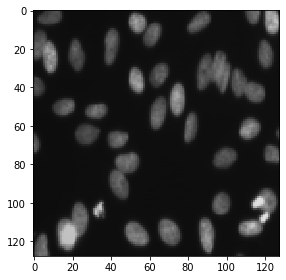

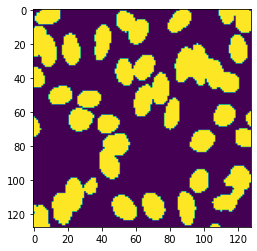

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


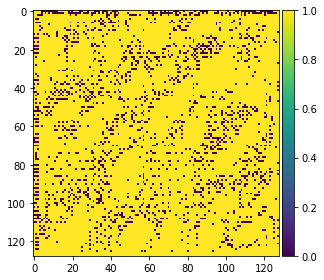

In [287]:
id_x = random.randint(0, len(predictiontrain1))
imshow(xtrain[id_x])
plt.show()
image = ytrain[id_x]
image = image.astype(np.uint8)
image = np.squeeze(image)
plt.imshow(image)
plt.show()
imshow(np.squeeze(predictiontrain1[id_x]))
plt.show() 

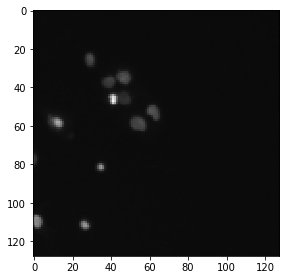

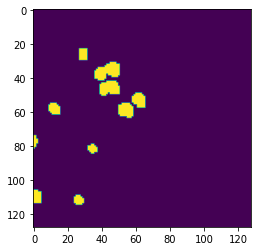

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


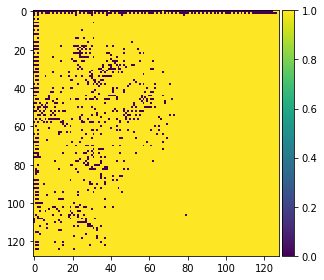

In [281]:
id_x = random.randint(0, len(predictionval1))
imshow(xtrain[int(xtrain.shape[0]*0.9):][id_x])
plt.show()
image = ytrain[int(ytrain.shape[0]*0.9):][id_x]
image = image.astype(np.uint8)
image = np.squeeze(image)
plt.imshow(image)
plt.show()
imshow(np.squeeze(predictionval1[id_x]))
plt.show()